# Red neuronal CNN

Esta red consiste en que tenemos un dataset que tienen distintos rostros de distintas personas con una cierta expresión. Estas estan divididas en enojo, miedo, felicidad, tristeza, sorpresa. La idea de la misma consiste en clasificar las entradas en alguna de estas categorias.

Primero hacemos import de las librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageOps




2025-12-08 15:33:58.794954: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 15:33:58.795390: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 15:33:58.855502: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 15:34:00.364586: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Ahora hacemos la importación de la data que esta en la carpeta de datasets y por medio de la funcion de keras de image_dataset_from_directory() cargamos en memoria las imágenes.

El tamaño de las imágenes se pone a 64 x 64 dado a que el tamaño de las imágenes medio es cercano ese valor (48 x 48), por lo que con ese tamaño tomamos en cuenta la mayoria de escenarios de nuestro dataset y aun nos da posibilidad de obtener información de las imágenes que tengan un mayor tamaño.

Otro parametro interesante es el label_mode dado a que el dataset esta en carpetas de las categorias, por lo que permite establecer las entradas de las imágenes a cierta categoria.

El batch_size consiste en cuantas imágenes estaremos agregando en memoria a la vez, cabe mencionar que no tiene nada que ver al batch_size del entrenamiento.

Tambien con image_dataset_from_directory() permite definir de una sola vez la x y la y, poque devuelve ambos valores.

In [2]:
DATASET_DIR = 'datasets'
IMG_WIDTH=128
IMG_HEIGHT=128
SEED=281
VALIDATION_SPLIT=0.2
BATCH_SIZE=64

train_ds = keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

print("Conteo de imagenes por tipo")
class_names = train_ds.class_names
image_counts = defaultdict(int)
for class_name in class_names:
    class_dir = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_dir):
        count = len(os.listdir(class_dir))
        image_counts[class_name] = count
        print(f"{class_name}: {count} images")



Found 59078 files belonging to 5 classes.
Using 47263 files for training.


E0000 00:00:1765229654.519050   15052 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765229654.529158   15052 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 59078 files belonging to 5 classes.
Using 11815 files for validation.
Conteo de imagenes por tipo
Angry: 10148 images
Fear: 9732 images
Happy: 18439 images
Sad: 12552 images
Suprise: 8207 images


Ahora, podemos definir el modelo, el cual se explica a continuación:

- La entrada es de las imagenes convertidas, con 3 filas que representan las capas de color
- Se aplica una capa de rescalamiento, para la normalización de las imágenes, siendo los 255, los valores de los pixeles en cada capa de color.
- Luego se tienen capas de convolución 2D con funcion relu de activación de 32 a 128 neuronas para ir tomando los elementos de la imagen de los mas pequeños a los mas grandes
- Luegos estan las capas de MaxPooling para hacer las operaciones convulocionales y se establecen de 2x2
- Luego hay una capa de droput para evitar el overfittig
- Luego una capar Flattern, para vectorizar las salidas de las imágenes
- Por úlitmo una capa de salida softmax que permite darnos una salida con las probabilidades de cada una de la clasificación de la imagen a verificar

Con respecto a la compilacion:

- Optimizador Adam
- Función de perdida crossnetropy

In [3]:
model = keras.Sequential([
    layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Ahora se procede con el proceso de entranamiento, y se define con una función callback que permite cancelar el proceso si se nota que no existe un ajuste en 5 epoch seguidas.

Luego se procesde a grabar el modelo y a graficar los resultados

Epoch 1/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 188s 253ms/step - accuracy: 0.4406 - loss: 1.3390 - val_accuracy: 0.5363 - val_loss: 1.1418
Epoch 2/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 183s 248ms/step - accuracy: 0.5541 - loss: 1.1036 - val_accuracy: 0.5943 - val_loss: 1.0176
Epoch 3/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 188s 255ms/step - accuracy: 0.6055 - loss: 0.9914 - val_accuracy: 0.6216 - val_loss: 0.9480
Epoch 4/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 189s 256ms/step - accuracy: 0.6437 - loss: 0.9004 - val_accuracy: 0.6587 - val_loss: 0.8662
Epoch 5/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 185s 250ms/step - accuracy: 0.6821 - loss: 0.8155 - val_accuracy: 0.6851 - val_loss: 0.8157
Epoch 6/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 184s 249ms/step - accuracy: 0.7093 - loss: 0.7420 - val_accuracy: 0.7044 - val_loss: 0.7763
Epoch 7/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 185s 250ms/step - accuracy: 0.7425 - loss: 0.6723 - val_accuracy: 0.7205 - val_loss: 0.7357
Epoch 8/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 185s 250ms/step - accuracy: 0.7666 -

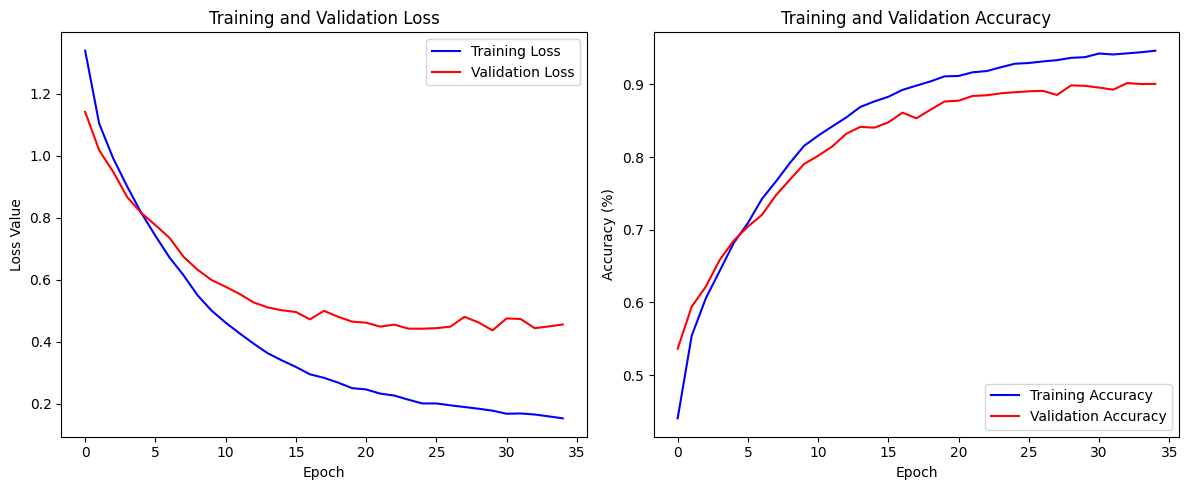

In [4]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)
model.save('cnn_model.keras')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 5))

# --- Plot 1: Loss ---
plt.subplot(1, 2, 1) # 1 row, 2 columns, plot 1
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')

# --- Plot 2: Accuracy ---
plt.subplot(1, 2, 2) # 1 row, 2 columns, plot 2
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

Ahora procedemos a hacer una prueba del modelo, con imagenes sacadas de internet de la carpeta test

In [15]:
test_dir = 'test'
imgs = sorted(os.listdir(test_dir))
for fn in imgs:
    fp = os.path.join(test_dir, fn)
    img = image.load_img(fp, target_size=(IMG_WIDTH, IMG_HEIGHT))
    arr = image.img_to_array(img)             
    arr = np.expand_dims(arr, 0)                       # batch dim
    probs = model.predict(arr, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    print(f"{fn} -> {class_names[pred_idx]} ({probs[pred_idx]:.3f})")

angry.png -> Angry (0.762)
fear.png -> Fear (0.956)
happy.png -> Happy (1.000)
sad.png -> Sad (0.612)
surprise.png -> Suprise (0.980)


# Análisis de resultados

Con respecto a este ejemplo, creo que se pudo llegar a un resultado aceptable, dado a que las gráficas 